# 2022-02-25 SVD Geometry

## Last time

* Comparison of interfaces
* Profiling
* Cholesky QR
* Matrix norms and conditioning

## Today

* Solving least squares problems
* Geometry of the SVD

In [1]:
using LinearAlgebra
using Plots
default(linewidth=4, legendfontsize=12)

function vander(x, k=nothing)
    if isnothing(k)
        k = length(x)
    end
    m = length(x)
    V = ones(m, k)
    for j in 2:k
        V[:, j] = V[:, j-1] .* x
    end
    V
end

function gram_schmidt_classical(A)
    m, n = size(A)
    Q = zeros(m, n)
    R = zeros(n, n)
    for j in 1:n
        v = A[:,j]
        R[1:j-1,j] = Q[:,1:j-1]' * v
        v -= Q[:,1:j-1] * R[1:j-1,j]
        R[j,j] = norm(v)
        Q[:,j] = v / R[j,j]
    end
    Q, R
end

function qr_householder(A)
    m, n = size(A)
    R = copy(A)
    V = [] # list of reflectors
    for j in 1:n
        v = copy(R[j:end, j])
        v[1] += sign(v[1]) * norm(v) # <---
        v = normalize(v)
        R[j:end,j:end] -= 2 * v * v' * R[j:end,j:end]
        push!(V, v)
    end
    V, R
end

function qr_chol(A)
    R = cholesky(A' * A).U
    Q = A / R
    Q, R
end

function qr_chol2(A)
    Q, R = qr_chol(A)
    Q, R1 = qr_chol(Q)
    Q, R1 * R
end

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1423


qr_chol2 (generic function with 1 method)

## Condition number of the matrix

The condition number of matrix-vector multiplication depends on the vector.  The condition number of the matrix is the worst case (maximum) of the condition number for any vector, i.e.,

$$ \kappa(A) = \max_{x \ne 0} \lVert A \rVert \frac{\lVert x \rVert}{\lVert A x \rVert} .$$

If $A$ is invertible, then we can rephrase as

$$ \kappa(A) = \max_{x \ne 0} \lVert A \rVert \frac{\lVert A^{-1} (A x) \rVert}{\lVert A x \rVert} =
\max_{A x \ne 0} \lVert A \rVert \frac{\lVert A^{-1} (A x) \rVert}{\lVert A x \rVert} = \lVert A \rVert \lVert A^{-1} \rVert . $$

Evidently multiplying by a matrix is just as ill-conditioned of an operation as solving a linear system using that matrix.

# Matrix norms induced by vector norms

$$ \lVert A \rVert = \max_{\lVert x \rVert = 1} \lVert A x \rVert . $$

# Condition number via SVD

$$ \kappa(A) = \lVert A \rVert \ \lVert A^{-1} \rVert $$

Or, in terms of the SVD

$$ U \Sigma V^T = \texttt{svd}(A) $$
where
$$ \Sigma = \begin{bmatrix} \sigma_{\max} && \\ & \ddots & \\ && \sigma_{\min} \end{bmatrix}, $$

$$ \kappa(A) = \frac{\sigma_{\max}}{\sigma_{\min}} = \texttt{cond}(A) $$

## Least squares and the normal equations

A **least squares problem** takes the form: given an $m\times n$ matrix $A$ ($m \ge n$), find $x$ such that
$$ \lVert Ax - b \rVert $$
is minimized.  If $A$ is square and full rank, then this minimizer will satisfy $A x - b = 0$, but that is not the case in general because $b$ is not in the range of $A$.
The residual $A x - b$ must be orthogonal to the range of $A$.

* Is this the same as saying $A^T (A x - b) = 0$?
* If $QR = A$, is it the same as $Q^T (A x - b) = 0$?

We showed that $QQ^T$ is an orthogonal projector onto the range of $Q$.  If $QR = A$,
$$ QQ^T (A x - b) = QQ^T(Q R x - b) = Q (Q^T Q) R x - QQ^T b = QR x - QQ^T b = A x - QQ^T b . $$
So if $b$ is in the range of $A$, we can solve $A x = b$.  If not, we need only *orthogonally* project $b$ into the range of $A$.

# The Professional's Way: QR (Householder)

Solve $R x = Q^T b$.

* QR factorization costs $2 m n^2 - \frac 2 3 n^3$ operations and is done once per matrix $A$.
* Computing $Q^T b$ costs $4 (m-n)n + 2 n^2 = 4 mn - 2n^2$ (using the elementary reflectors, which are stable and lower storage than naive storage of $Q$).
* Solving with $R$ costs $n^2$ operations.  Total cost per right hand side is thus $4 m n - n^2$.

This method is stable and accurate.

# The 737 MAX Way: Cholesky/Normal Equations
## fast, unregulated, and dangerous

The mathematically equivalent form $(A^T A) x = A^T b$ are called the **normal equations**.  The solution process involves factoring the symmetric and positive definite $n\times n$ matrix $A^T A$.

* Computing $A^T A$ costs $m n^2$ flops, exploiting symmetry.
* Factoring $A^T A = R^T R$ costs $\frac 1 3 n^3$ flops.  The total factorization cost is thus $m n^2 + \frac 1 3 n^3$.
* Computing $A^T b$ costs $2 m n$.
* Solving with $R^T$ costs $n^2$.
* Solving with $R$ costs $n^2$.  Total cost per right hand side is thus $2 m n + 2 n^2$.

The product $A^T A$ is ill-conditioned: $\kappa(A^T A) = \kappa(A)^2$ and can reduce the accuracy of a least squares solution.

# The Prepper's Way: Singular Value Decomposition

$$ U \Sigma V^T = A $$
where $U$ and $V$ have orthonormal columns and $\Sigma$ is diagonal with nonnegative entries.
The entries of $\Sigma$ are called **singular values** and this decomposition is the **singular value decomposition** (SVD).
It may remind you of an eigenvalue decomposition $X \Lambda X^{-1} = A$, but
* the SVD exists for all matrices (including non-square and deficient matrices)
* $U,V$ have orthogonal columns (while $X$ can be arbitrarily ill-conditioned).
Indeed, if a matrix is symmetric and positive definite (all positive eigenvalues), then $U=V$ and $\Sigma = \Lambda$.
Computing an SVD requires a somewhat complicated iterative algorithm, but a crude estimate of the cost is $2 m n^2 + 11 n^3$.  Note that this is similar to the cost of $QR$ when $m \gg n$, but much more expensive for square matrices.
Solving with the SVD involves
* Compute $U^T b$ at a cost of $2 m n$.
* Solve with the diagonal $n\times n$ matrix $\Sigma$ at a cost of $n$.
* Apply $V$ at a cost of $2 n^2$.  The total cost per right hand side is thus $2 m n + 2n^2$.

## SVD gives the unique minimum norm solution when $A$ is rank deficient

# Activity: Geometry of the Singular Value Decomposition

In [7]:
default(aspect_ratio=:equal)

function peanut()
    theta = LinRange(0, 2*pi, 50)
    r = 1 .+ .4*sin.(3*theta) + .6*sin.(2*theta)
    r' .* [cos.(theta) sin.(theta)]'
end

function circle()
    theta = LinRange(0, 2*pi, 50)
    [cos.(theta) sin.(theta)]'
end

function Aplot(A)
    "Plot a transformation from X to Y"
    X = peanut()
    Y = A * X
    p = scatter(X[1,:], X[2,:], label="in")
    scatter!(p, Y[1,:], Y[2,:], label="out")
    X = circle()
    Y = A * X
    q = scatter(X[1,:], X[2,:], label="in")
    scatter!(q, Y[1,:], Y[2,:], label="out")
    plot(p, q, layout=2)
end

Aplot (generic function with 1 method)

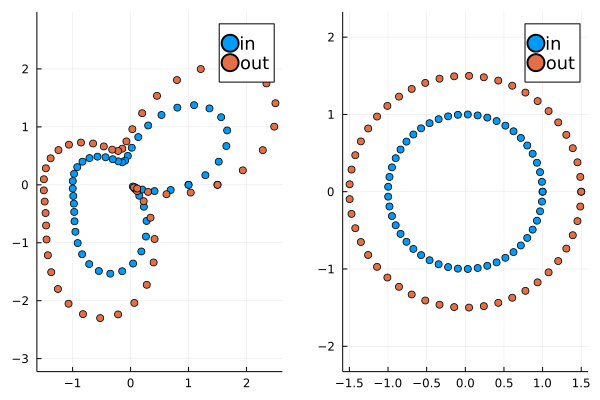

In [9]:
Aplot(1.5*I)

# Diagonal matrices

Perhaps the simplest transformation is a scalar multiple of the identity.


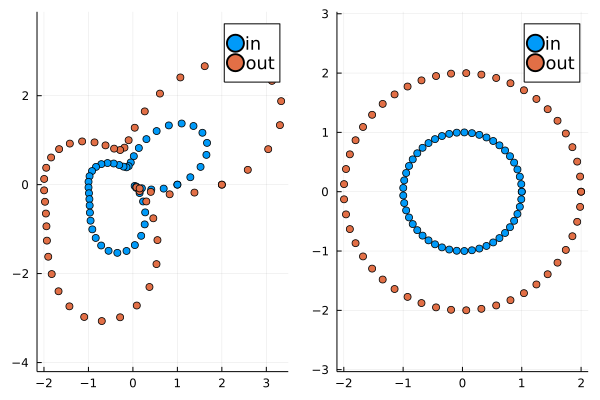

In [10]:
Aplot([2 0; 0 2])

The diagonal entries can be different sizes.

$$ A = \begin{bmatrix} 2 & 0 \\ 0 & .5 \end{bmatrix}$$

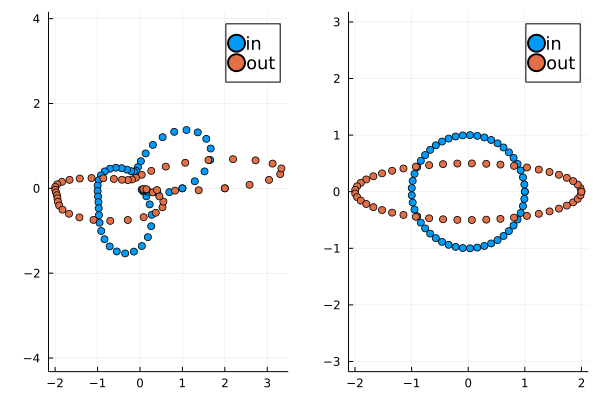

In [11]:
Aplot([2 0; 0 .5])

The circles becomes an **ellipse** that is **aligned with the coordinate axes**

# Givens Rotation (as example of orthogonal matrix)

We can rotate the input using a $2\times 2$ matrix, parametrized by $\theta$. Its transpose rotates in the opposite direction.


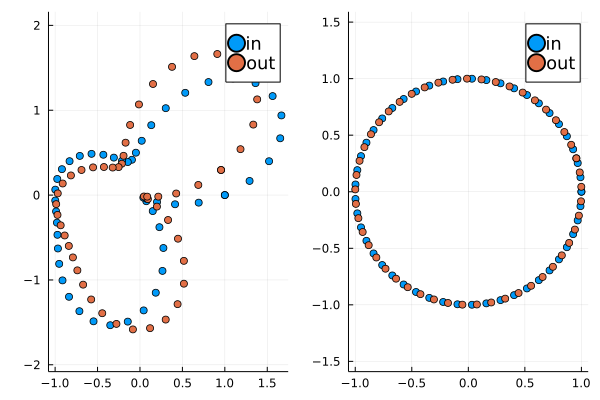

In [12]:
function givens(theta)
    s = sin(theta)
    c = cos(theta)
    [c -s; s c]
end

G = givens(0.3)
Aplot(G)

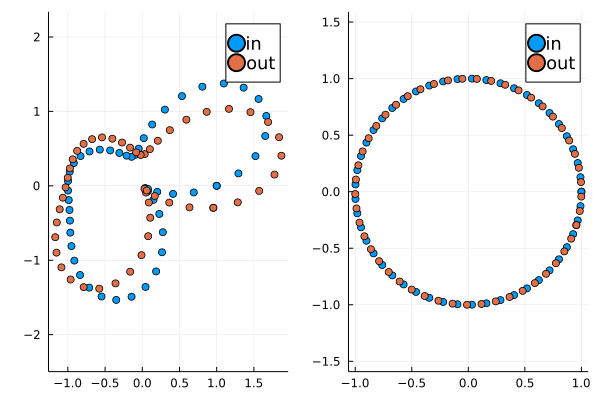

In [13]:
Aplot(G')

# Reflection

We've previously seen that reflectors have the form $F = I - 2 v v^T$ where $v$ is a normalized vector. Reflectors satisfy $F^T F = I$ and $F = F^T$, thus $F^2 = I$.

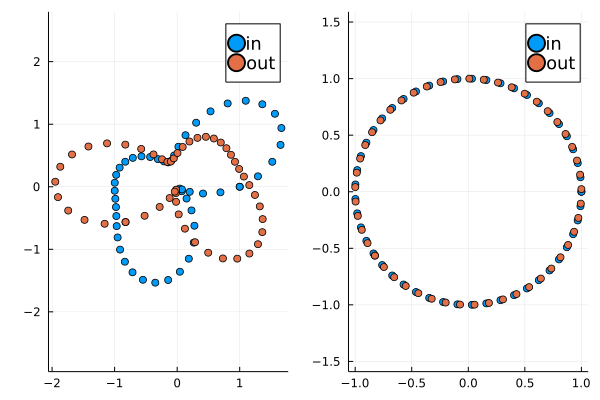

In [14]:
function reflect(theta)
    v = [cos(theta), sin(theta)]
    I - 2 * v * v'
end

Aplot(reflect(0.3))

# Singular Value Decomposition

The SVD is $A = U \Sigma V^T$ where $U$ and $V$ have orthonormal columns and $\Sigma$ is diagonal with nonnegative entries. It exists for any matrix (non-square, singular, etc.). If we think of orthogonal matrices as reflections/rotations, this says any matrix can be represented as reflect/rotate, diagonally scale, and reflect/rotate again.

Let's try a random symmetric matrix.

det(A) = 0.1399560771029573


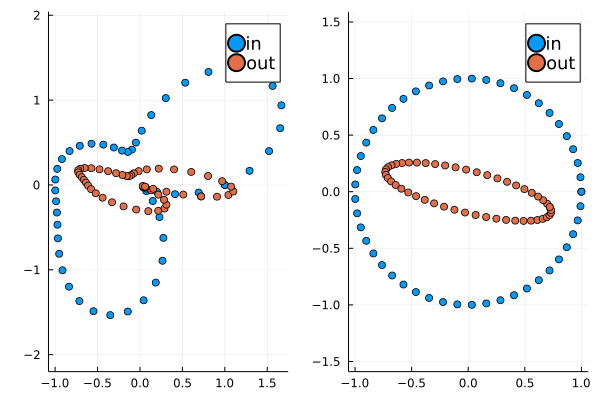

In [51]:
A = randn(2, 2)
A = A' * A #A += A' # make symmetric
@show det(A) # Positive means orientation is preserved
Aplot(A)

norm(U * diagm(S) * V' - A) = 2.5133742693021536e-16


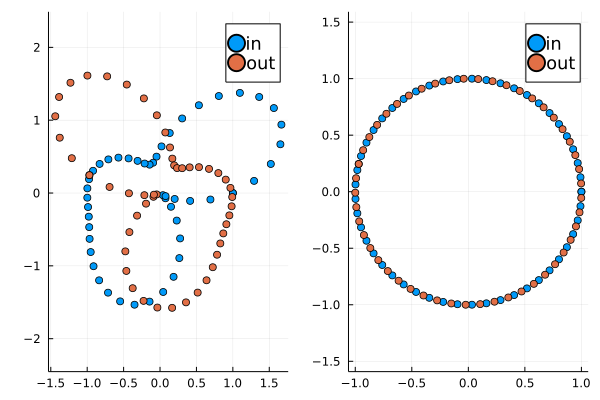

In [55]:
U, S, V = svd(A)
@show norm(U * diagm(S) * V' - A) # Should be zero
Aplot(V') # Rotate/reflect in preparation for scaling

* What visual features indicate that this is a symmetric matrix?
* Is the orthogonal matrix a reflection or rotation?
    * Does this change when the determinant is positive versus negative (rerun the cell above as needed).



# Parts of the SVD

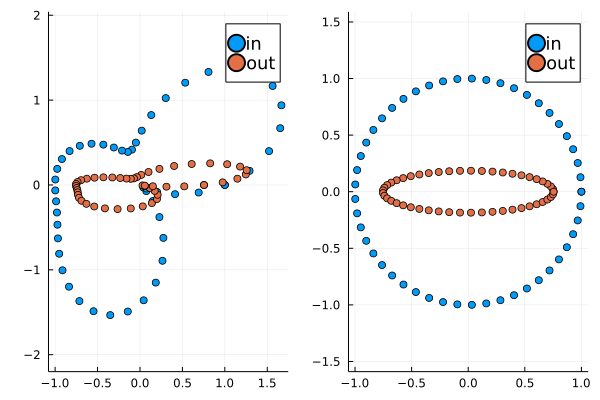

In [56]:
Aplot(diagm(S)) # scale along axes

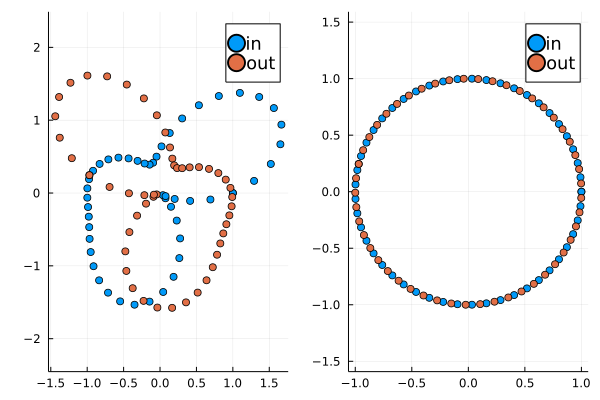

In [57]:
Aplot(U) # rotate/reflect back

# Putting it together

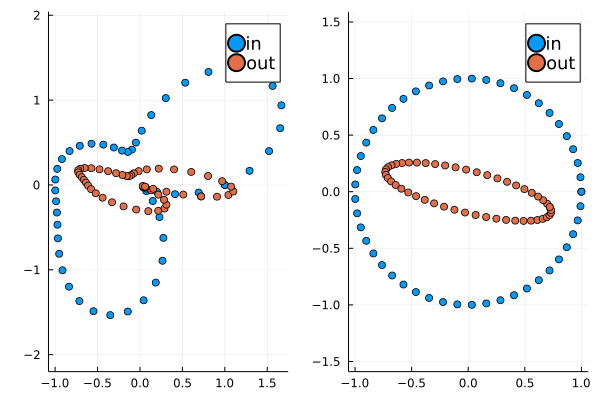

In [58]:
Aplot(U * diagm(S) * V')

# Observations

* The circle always maps to an ellipse
* The $U$ and $V$ factors may reflect even when $\det A > 0$

# What makes a matrix ill-conditioned?

In [63]:
A = [10 5; .9 .5]
@show cond(A)
svdvals(A)

cond(A) = 252.116033572376


2-element Vector{Float64}:
 11.22755613596245
  0.0445332888070338

In [64]:
m = 100
x = LinRange(-1, 1, m)
A = vander(x, 20)
@show cond(A)
svdvals(A)

cond(A) = 7.206778417359946e6


20-element Vector{Float64}:
 11.510601491136654
  8.993572449917359
  5.907360126610744
  3.602915483194609
  1.9769729310318829
  1.0983103765769855
  0.5392322016751732
  0.2820042230178556
  0.12425066006852739
  0.06183086124622073
  0.02424292914634914
  0.011556331531623497
  0.003964435582121709
  0.0018189836735690204
  0.0005298822985646023
  0.0002348766098794304
  5.487089394455714e-5
  2.3566694052672652e-5
  3.828636525152325e-6
  1.5971909811198725e-6

## Orthogonal transformations don't affect singular values (or conditioning)

S = [0.5180264838912266, 0.3200666128955899]
S[1] / S[end] = 1.6184958474885163


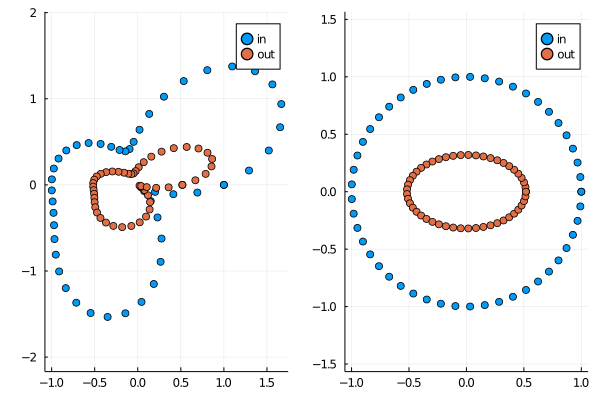

In [83]:
A = [3 0; 0 .5]
Q, _R = qr(randn(2,2))
B = Q * A * Q'
U, S, V = svd(randn(2,2))
@show S
@show S[1] / S[end]
Aplot(diagm(S))